In [1]:
import requests
import pandas as pd

def get_full_data(table_name):
    url = f"https://aetab8pjmb.us-east-1.awsapprunner.com/table/{table_name}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json().get('data', [])
            return pd.DataFrame(data)
        else:
            print(f"Warning: Failed to fetch data from {table_name}, status code: {response.status_code}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error while fetching {table_name}: {e}")
        return pd.DataFrame()

print("Fetching full data from server...")
df_wearable = get_full_data("wearable_vitals")
df_hosp = get_full_data("vitals_history")
df_ecg = get_full_data("ecg")

for df in [df_wearable, df_hosp, df_ecg]:
    if not df.empty:
        time_col = 'timestamp' if 'timestamp' in df.columns else 'recorded_on'
        df['std_timestamp'] = pd.to_datetime(df[time_col])
        df.sort_values('std_timestamp', inplace=True)


merged_df = pd.merge_asof(
    df_wearable.sort_values('std_timestamp'),
    df_hosp.sort_values('std_timestamp'),
    on='std_timestamp',
    by='patient_id',
    direction='nearest',
    suffixes=('_wear', '_hosp')
)

print("\n--- Patient 20 Final Aligned View ---")

available_cols = merged_df.columns.tolist()
cols_to_show = ['std_timestamp', 'steps']

for c in ['heart_rate', 'heart_rate_wear', 'heart_rate_hosp', 'hospital_hr', 'ecg_result']:
    if c in available_cols:
        cols_to_show.append(c)

final_output = merged_df[merged_df['patient_id'] == 20][cols_to_show]
print(final_output.tail())

final_output.to_csv("Patient_20_Integrated_Data.csv", index=False)


/Users/kezhuli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Fetching full data from server...

--- Patient 20 Final Aligned View ---
               std_timestamp  steps  heart_rate_wear  heart_rate_hosp
40 2026-01-14 17:15:02+00:00   4278                0             72.0
41 2026-01-21 17:29:42+00:00      0                0             72.0
42 2026-01-21 17:29:48+00:00      0                0             72.0
43 2026-01-28 17:07:14+00:00      0                0             72.0
44 2026-01-28 17:07:17+00:00      0                0             72.0


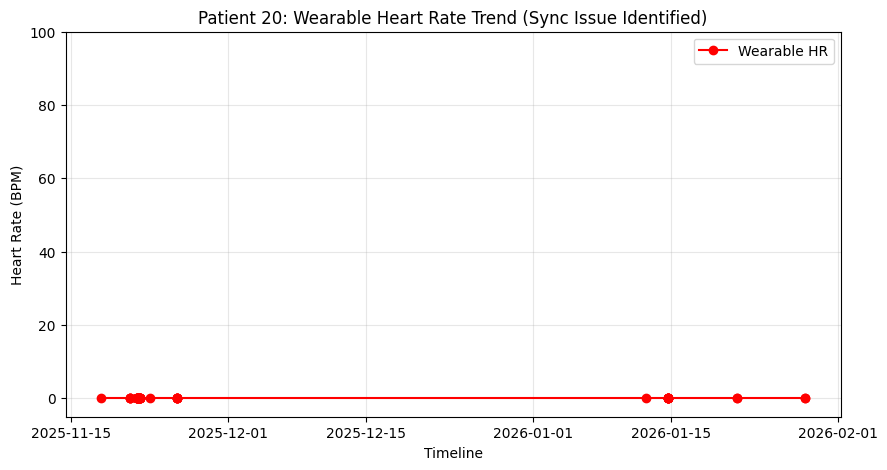

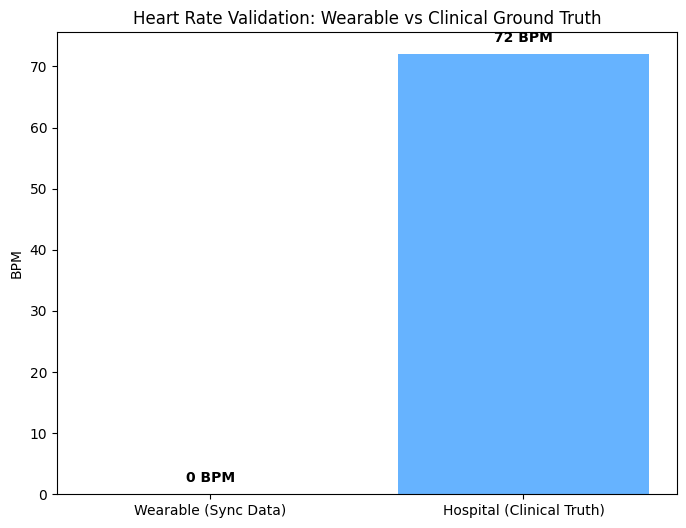

In [2]:
import matplotlib.pyplot as plt

# Reuse df_wearable, df_hosp from Cell 0 (run Cell 0 first)
p20_wear = df_wearable[df_wearable['patient_id'] == 20].copy()
p20_hosp = df_hosp[df_hosp['patient_id'] == 20].copy()

plt.figure(figsize=(10, 5))
plt.plot(p20_wear['std_timestamp'], p20_wear['heart_rate'], marker='o', color='red', label='Wearable HR')
plt.title('Patient 20: Wearable Heart Rate Trend (Sync Issue Identified)')
plt.xlabel('Timeline')
plt.ylabel('Heart Rate (BPM)')
plt.ylim(-5, 100)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

clinical_truth = p20_hosp['heart_rate'].iloc[-1] if not p20_hosp.empty else 0
wearable_avg = p20_wear['heart_rate'].mean()

categories = ['Wearable (Sync Data)', 'Hospital (Clinical Truth)']
values = [wearable_avg, clinical_truth]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=['#ff9999', '#66b3ff'])
plt.title('Heart Rate Validation: Wearable vs Clinical Ground Truth')
plt.ylabel('BPM')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{int(yval)} BPM', ha='center', fontweight='bold')

plt.show()